In [58]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import Imputer
from sklearn import preprocessing
from sklearn.base import BaseEstimator
import random
import seaborn as sns
import matplotlib.pyplot as plt
df2017 = pd.read_csv(r"C:\Users\micha\Desktop\Loan Stats\LoanStats_2017.csv")
df2016 = pd.read_csv(r"C:\Users\micha\Desktop\Loan Stats\LoanStats_2016.csv")
df2015 = pd.read_csv(r"C:\Users\micha\Desktop\Loan Stats\LoanStats_2015.csv")
df2014 = pd.read_csv(r"C:\Users\micha\Desktop\Loan Stats\LoanStats_2014.csv")
df2013 = pd.read_csv(r"C:\Users\micha\Desktop\Loan Stats\LoanStats_2013_to_2012.csv")
df2011 = pd.read_csv(r"C:\Users\micha\Desktop\Loan Stats\LoanStats_2011_to_2007.csv")

datasets = [df2017,df2016,df2015,df2014,df2013,df2011]
cols_to_keep = ['funded_amnt_inv',"int_rate","grade","sub_grade",'home_ownership','emp_length','purpose','annual_inc','issue_d',"loan_status",'purpose',
"addr_state",'dti','delinq_2yrs','revol_bal','total_acc',"pub_rec_bankruptcies"]

for i, data in enumerate(datasets):
    #Isolate for Individual and 36 months
    x = datasets[i]
    x = x[(x['application_type']=='Individual')& (x['term']==' 36 months')]
    #Remove all loan status categories besides Fully Paid and Charged Off. Since it is data over time, I want to
    #avoid double counting loans such as Late in 2011, which may be in default in 2017. Simlarly
    # if a loan shows 'Current' as a status this could fall into trouble in the future.
    x = x[x['loan_status']!="Current"]
    x = x[x['loan_status']!="Late (31-120 days)"]
    x = x[x['loan_status']!="Late (16-30 days)"]
    x = x[x['loan_status']!="In Grace Period"]
    x = x[x['loan_status']!="Default"]
    x = x[x['loan_status']!="Does not meet the credit policy. Status:Fully Paid"]
    x = x[x['loan_status']!="Does not meet the credit policy. Status:Charged Off"]
    
    #Drop non-relevant features
    x = x[cols_to_keep]
    
    #Make interest rate numeric by taking out the percentage
    x.int_rate = pd.Series(x.int_rate).str.replace('%', '').astype(float)

    #We will consider anything more than 30 days as in default
    x.loan_status = pd.Series(x.loan_status).replace("Fully Paid", 0)
    x.loan_status = pd.Series(x.loan_status).replace("Charged Off", 1)
    
    #Dealing with nulls on bankruptcies and delinquencies 
    x.pub_rec_bankruptcies.fillna(value=x.pub_rec_bankruptcies.mean(), inplace=True)
    x.total_acc.fillna(value=x.total_acc.mean(),inplace=True)
    x.delinq_2yrs.fillna(value=x.delinq_2yrs.mean(),inplace=True)
    
    #Remove any annual incomes above 10m as this is highly likely a mistake- these people would have family offices, not need Lending Club
    x = x[x['annual_inc']<10000000]
    datasets[i] = x
#Put all the data sets together                 
data = pd.concat(datasets)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 616110 entries, 98 to 39785
Data columns (total 17 columns):
funded_amnt_inv         616110 non-null float64
int_rate                616110 non-null float64
grade                   616110 non-null object
sub_grade               616110 non-null object
home_ownership          616110 non-null object
emp_length              616110 non-null object
purpose                 616110 non-null object
annual_inc              616110 non-null float64
issue_d                 616110 non-null object
loan_status             616110 non-null int64
purpose                 616110 non-null object
addr_state              616110 non-null object
dti                     616110 non-null float64
delinq_2yrs             616110 non-null float64
revol_bal               616110 non-null float64
total_acc               616110 non-null float64
pub_rec_bankruptcies    615413 non-null float64
dtypes: float64(8), int64(1), object(8)
memory usage: 84.6+ MB
None


In [59]:
mapping_dict = {

    "emp_length": {

        "10+ years": 10,

        "9 years": 9,

        "8 years": 8,

        "7 years": 7,

        "6 years": 6,

        "5 years": 5,

        "4 years": 4,

        "3 years": 3,

        "2 years": 2,

        "1 year": 1,

        "< 1 year": 0,

        "n/a":0,

 

    },

    "grade":{

        "A": 1,

        "B": 2,

        "C": 3,

        "D": 4,

        "E": 5,

        "F": 6,

        "G": 7

    },

    "home_ownership":{

        "NONE": 0,

        "OTHER": 1,

        "RENT": 2,

        'MORTGAGE': 3,

        'OWN': 4,

    },

    "purpose": {

        'credit_card': 1,

        'small_business': 2,

        'other': 3,

        'wedding': 4,

        'car': 5,

        'debt_consolidation': 6,

        'home_improvement': 7,

        'major_purchase': 8,

        'medical': 9,

        'moving': 10,

        'vacation': 11,

        'house': 12,

        'renewable_energy': 13,

        'educational': 14

    }

}

 

data = data.replace(mapping_dict)

 

reg_cols = ['funded_amnt_inv', 'int_rate', 'annual_inc', 'delinq_2yrs','home_ownership','revol_bal','purpose','emp_length','total_acc', 'pub_rec_bankruptcies']

dummy = ['home_ownership','sub_grade',"addr_state",'purpose']

reg_data = data[reg_cols]

HY_data = reg_data[reg_data['int_rate']>25]

HY_y = data[data['int_rate']>25].loan_status

In [60]:
lr = LogisticRegression(C=.01,class_weight=None,fit_intercept=True)
HY_data = reg_data
HY_y = data['loan_status']
model = lr.fit(X,y)
cross_val_score(model,X,y,cv=5).mean()

0.83431854703032349

In [61]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
HY_data = reg_data
HY_y = data['loan_status']
model = rfc.fit(X,y)
cross_val_score(rfc,X,y,cv=5).mean()

0.78885770776839581

In [ ]:
rfc.feature_importances_()

In [ ]:
from sklearn.svm import SVC
svc = SVC()
HY_data = reg_data
HY_y = data['loan_status']
svc = svc.fit(X,y)
cross_val_score(svc,X,y,cv=5).mean()

In [64]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
HY_data = reg_data
HY_y = data['loan_status']
model = knn.fit(X,y)
cross_val_score(knn,X,y,cv=5).mean()

0.80897079565328822

In [ ]:
from sklearn.linear_model import 
knn = KNeighborsClassifier()
HY_data = reg_data
HY_y = data['loan_status']
model = knn.fit(X,y)
cross_val_score(knn,X,y,cv=5).mean()

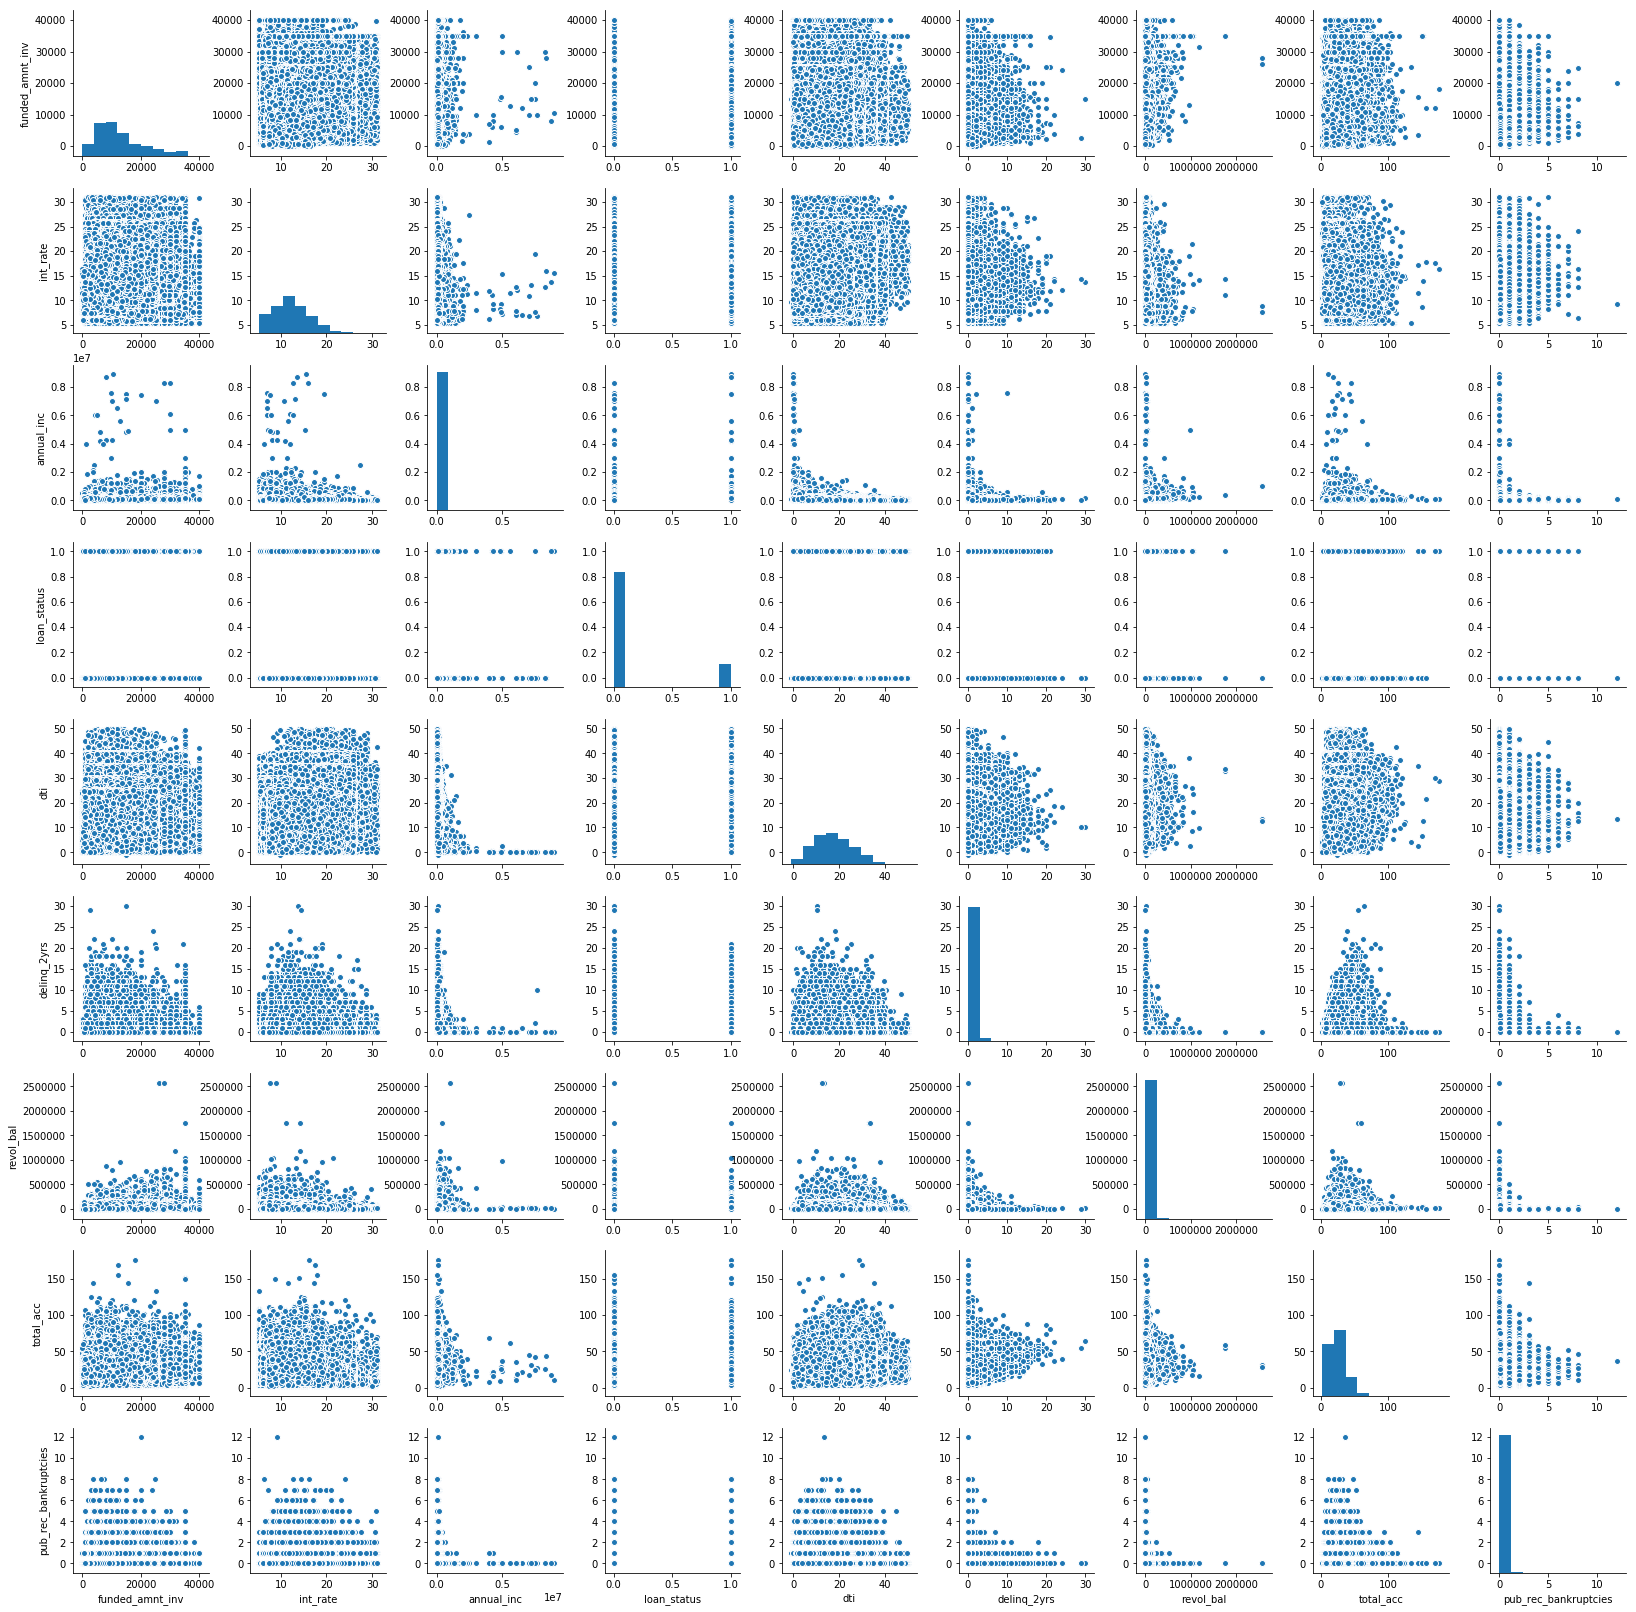

In [180]:
import matplotlib.pyplot as plt
sns.pairplot(data,hue="grade")
plt.show()


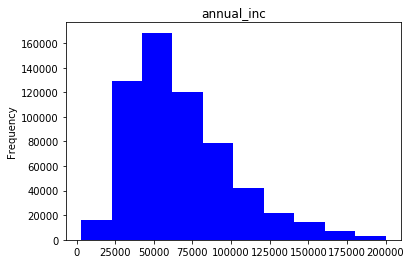

In [20]:
data2 = data[data['annual_inc'] <200000]
data2.annual_inc.plot(kind='hist',color='b',bins=10)
plt.title("annual_inc")
plt.show()

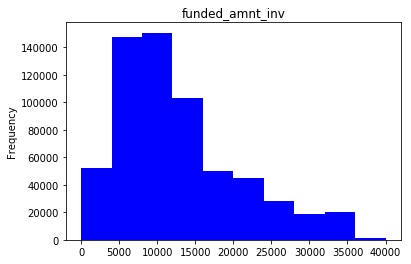

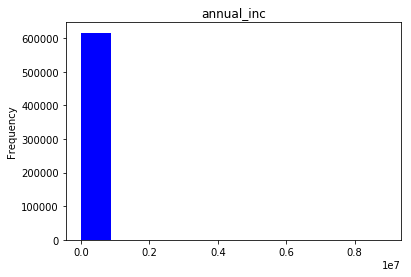

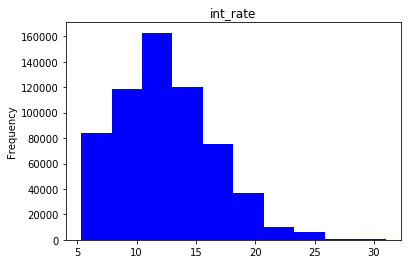

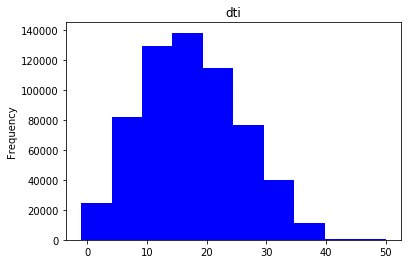

In [418]:
for x in ['funded_amnt_inv','annual_inc',"int_rate",'dti','grade']:
    data[x].plot(kind='hist',bins=10, color = "b")
    plt.title(x)
    plt.show()

In [384]:
data.corr()
#No two features are extremely highly correlated

,funded_amnt_inv,int_rate,annual_inc,loan_status,dti,delinq_2yrs,revol_bal,total_acc,pub_rec_bankruptcies
funded_amnt_inv,1.000000,0.013377,0.509816,NaN,0.000482,0.026033,0.330640,0.204127,-0.071612
int_rate,0.013377,1.000000,-0.136234,NaN,0.134700,0.018512,-0.078707,-0.100699,0.019835
annual_inc,0.509816,-0.136234,1.000000,NaN,-0.180286,0.099426,0.356017,0.286974,-0.043783
loan_status,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dti,0.000482,0.134700,-0.180286,NaN,1.000000,-0.018461,0.181900,0.238269,-0.007084
delinq_2yrs,0.026033,0.018512,0.099426,NaN,-0.018461,1.000000,-0.042159,0.151419,-0.037914
revol_bal,0.330640,-0.078707,0.356017,NaN,0.181900,-0.042159,1.000000,0.221474,-0.124746
total_acc,0.204127,-0.100699,0.286974,NaN,0.238269,0.151419,0.221474,1.000000,0.075409
pub_rec_bankruptcies,-0.071612,0.019835,-0.043783,NaN,-0.007084,-0.037914,-0.124746,0.075409,1.000000


Text(0.5,0,u'Default Percentage')

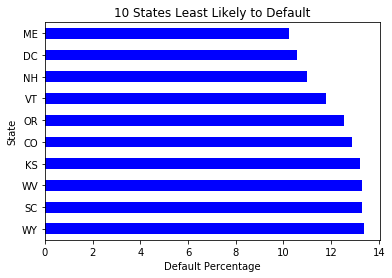

In [406]:
defaults_by_state = data.groupby('addr_state').loan_status.sum()
total_loans_by_state = data.groupby('addr_state').loan_status.count()
default_percentage = (defaults_by_state/total_loans_by_state)*100
default_percentage.sort_values(ascending=False).tail(10).plot.barh(color='b')
plt.title('10 States Least Likely to Default')
plt.ylabel("State")
plt.xlabel('Default Percentage')

Text(0.5,0,u'Default Percentage')

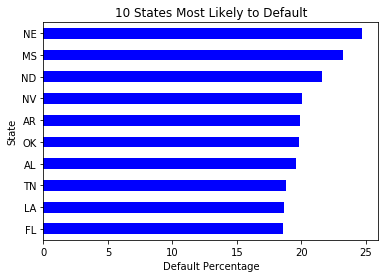

In [407]:
defaults_by_state = data.groupby('addr_state').loan_status.sum()
total_loans_by_state = data.groupby('addr_state').loan_status.count()
default_percentage = (defaults_by_state/total_loans_by_state)*100
default_percentage.sort_values(ascending=True).tail(10).plot.barh(color='b')
plt.title('10 States Most Likely to Default')
plt.ylabel("State")
plt.xlabel('Default Percentage')

In [408]:
grades = ['A',"B","C","D","E",'F']
for grade in grades:
    grade_data = data[data["grade"]==grade]
    Charged_Off = len(grade_data[grade_data['loan_status']== 1])
    Total_Loans = len(grade_data["loan_status"])
    Default_Percentage = (float(Charged_Off)/float(Total_Loans))*100
    Default_Percentage = round(Default_Percentage,2)
    Average_Annual_Interest_Rate = round(grade_data.int_rate.mean(),2)
    Total_Interest_Rate = round(((((1+(grade_data.int_rate.mean()/100/12))**36)-1)*100),2)
    #Simplyfing and conservative assumption that loans in default will default on day 1 and there is no recovery. Real EV
    #would be higher.
    Expected_Value = round((1-(Default_Percentage/100))*(1+(Total_Interest_Rate/100)),2)
    print("Grade: %s" % grade, "Default Percentage: %s" % Default_Percentage, "Total Loans: %s" %Total_Loans
          , "Avg. Interest Rate: %s" %Average_Annual_Interest_Rate, "Total Interest Rate: %s" %Total_Interest_Rate,
         "Expected Value %s" %Expected_Value)

('Grade: A', 'Default Percentage: 6.44', 'Total Loans: 129833', 'Avg. Interest Rate: 7.25', 'Total Interest Rate: 24.22', 'Expected Value 1.16')
('Grade: B', 'Default Percentage: 12.91', 'Total Loans: 208578', 'Avg. Interest Rate: 10.94', 'Total Interest Rate: 38.66', 'Expected Value 1.21')
('Grade: C', 'Default Percentage: 20.75', 'Total Loans: 166595', 'Avg. Interest Rate: 14.04', 'Total Interest Rate: 52.0', 'Expected Value 1.2')
('Grade: D', 'Default Percentage: 26.99', 'Total Loans: 81123', 'Avg. Interest Rate: 17.48', 'Total Interest Rate: 68.3', 'Expected Value 1.23')
('Grade: E', 'Default Percentage: 33.4', 'Total Loans: 23814', 'Avg. Interest Rate: 20.63', 'Total Interest Rate: 84.71', 'Expected Value 1.23')
('Grade: F', 'Default Percentage: 37.65', 'Total Loans: 5304', 'Avg. Interest Rate: 24.41', 'Total Interest Rate: 106.47', 'Expected Value 1.29')


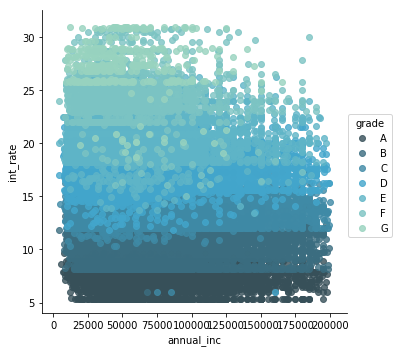

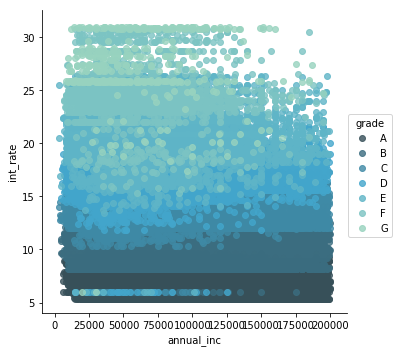

In [415]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
data1 = data[(data['annual_inc']<200000)]
data1 = data1[data1['loan_status']==1]

sns.lmplot(x = 'annual_inc',y="int_rate",data=data1, hue='grade',hue_order=['A',"B",'C',"D","E","F","G"],fit_reg=False,
          palette="GnBu_d")

data2 = data[(data['annual_inc']<200000)]
data2 = data2[data2['loan_status']==0]

sns.lmplot(x = 'annual_inc',y="int_rate",data=data2, hue='grade',hue_order=['A',"B",'C',"D","E","F","G"],fit_reg=False,
          palette="GnBu_d")

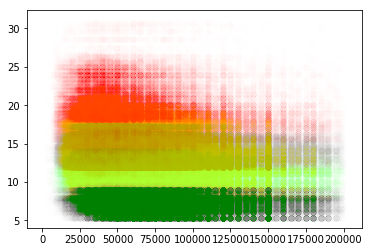

In [125]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
data_A = data[(data['annual_inc']<200000)&(data['grade']=="A")]
x = np.array(data_A['annual_inc'])
y = np.array(data_A['int_rate'])
plt.scatter(x,y,alpha=.005, c='g')

data_B = data[(data['annual_inc']<200000)&(data['grade']=="B")]
x = np.array(data_B['annual_inc'])
y = np.array(data_B['int_rate'])
plt.scatter(x,y,alpha=.005, c='greenyellow')

data_C = data[(data['annual_inc']<200000)&(data['grade']=="C")]
x = np.array(data_C['annual_inc'])
y = np.array(data_C['int_rate'])
plt.scatter(x,y,alpha=.005,c='y')

data_D = data[(data['annual_inc']<200000)&(data['grade']=="D")]
x = np.array(data_D['annual_inc'])
y = np.array(data_D['int_rate'])
plt.scatter(x,y,alpha=.005,c='orange')


data_E = data[(data['annual_inc']<200000)&(data['grade']=="E")]
x = np.array(data_E['annual_inc'])
y = np.array(data_E['int_rate'])
plt.scatter(x,y,alpha=.005,c="orangered")

data_F = data[(data['annual_inc']<200000)&(data['grade']=="F")]
x = np.array(data_F['annual_inc'])
y = np.array(data_F['int_rate'])
plt.scatter(x,y,alpha=.005,c='red')

In [24]:
reg_cols = ['funded_amnt_inv', 'int_rate', 'annual_inc', 'delinq_2yrs', 'revol_bal', 'total_acc', 'pub_rec_bankruptcies']

In [25]:
dummy = ['home_ownership','sub_grade',"addr_state",'purpose']
reg_data = data[reg_cols]

In [26]:
dummies = pd.get_dummies(data[dummy])

In [7]:
data_dummies = pd.concat([reg_data,dummies],axis=1)

In [65]:
#With State, Home Ownership, Sub-Grade, and Loan Purpose - Did not end up using this one
from sklearn.linear_model import LinearRegression
from scipy.sparse import csr_matrix
from scipy import sparse

logreg = LogisticRegression()
sparse_data = sparse.csr_matrix(data_dummies)
X_train, X_test, y_train, y_test = train_test_split(sparse_data,data['loan_status'], test_size = .3)
X = sparse_data
y = data['loan_status']
model = clf.fit(X_train,y_train)
predictions = model.predict(X_test)


In [69]:
model.score(X_test,y_test)

0.83460745646069701

In [42]:
#This is the one I used
from sklearn.grid_search import GridSearchCV
logreg = LogisticRegression(C=.01,class_weight=None,fit_intercept=True)
X = reg_data
y = data['loan_status']
model = logreg.fit(X,y)
cross_val_score(model,X,y,cv=5).mean()


0.83431854703032349

In [47]:
np.exp(model.coef_)

array([[ 1.00000059,  0.99016654,  0.99998852,  1.00033936,  1.00000136,
         0.97389292,  0.99978068]])

In [28]:
param_grid = {'C':[.01,.05,.1,.2,.3,.4,.5,.6,.7,.8,.9,1],"fit_intercept":[True,False]}
validator = GridSearchCV(model,param_grid=param_grid)
validator.fit(X,y)#This is the one I used
from sklearn.grid_search import GridSearchCV
logreg = LogisticRegression(C=.01,class_weight=None,fit_intercept=True)
X = reg_data
y = data['loan_status']
model = logreg.fit(X,y)
cross_val_score(model,X,y,cv=5).mean()


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 'fit_intercept': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

,funded_amnt_inv,int_rate,annual_inc,delinq_2yrs,revol_bal,total_acc,pub_rec_bankruptcies
1206,10200.0,30.65,30000.0,0.0,1768.0,27.0,0.0
9277,5000.0,25.82,22000.0,1.0,7500.0,21.0,0.0
9770,6000.0,25.82,20000.0,0.0,0.0,5.0,0.0
11765,35000.0,26.30,200000.0,1.0,21948.0,28.0,0.0
12282,13275.0,30.84,68000.0,0.0,9434.0,34.0,1.0
13724,11675.0,30.79,80600.0,0.0,3163.0,16.0,1.0
13891,19425.0,30.99,54000.0,0.0,17324.0,27.0,0.0
14908,14000.0,30.17,40000.0,0.0,3956.0,35.0,0.0
18769,17750.0,30.84,149000.0,0.0,51888.0,36.0,0.0
19812,16000.0,25.82,92500.0,0.0,12313.0,23.0,0.0


0.57720620638468145

In [29]:
print(validator.best_score_)
print(validator.best_params_)

0.834318547013
{'C': 0.01, 'fit_intercept': True}


In [126]:
#Without
from sklearn.linear_model import LinearRegression
from scipy.sparse import csr_matrix
from scipy import sparse
from sklearn.model_selection import train_test_split
X_simple_train, X_simple_test, y_simple_train, y_simple_test = train_test_split(reg_data,data['loan_status'], test_size = .3)
logreg = LogisticRegression()
X_simple = reg_data['int_rate']
y_simple = data['loan_status']
model_simple = clf.fit(X_simple_train,y_simple_train)
predictions = model_simple.predict(X_simple_test)


In [102]:
#Linear Regression with all features
lm = LinearRegression()
sparse_data = sparse.csr_matrix(data_dummies)
X_train, X_test, y_train, y_test = train_test_split(sparse_data,data['loan_status'], test_size = .3)
X = sparse_data
y = data['loan_status']
model = lm.fit(X_train,y_train)
predictions = model.predict(X_test)
model.score(X_test,y_test)
    

0.051805981783464072

In [40]:
lm = LinearRegression()
sparse_data = sparse.csr_matrix(data_dummies)
X_simple_train, X_simple_test, y_simple_train, y_simple_test = train_test_split(reg_data,data['loan_status'], test_size = .3)
X = reg_data
y = data['loan_status']
model = lm.fit(X_simple_train,y_simple_train)
predictions = model.predict(X_simple_test)
model.score(X_simple_test,y_simple_test)

NameError: name 'sparse' is not defined